# Analyze Training Results
Note:  You must run the previous notebook to generate debugger artifacts

In [1]:
!pip install -q --upgrade pip
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0

In [2]:
%store -r training_job_debugger_artifacts_path

In [3]:
print(training_job_debugger_artifacts_path)

s3://sagemaker-us-west-2-086401037028/tensorflow-training-2020-04-25-18-34-53-740/debug-output


## Analyze Tensors

Before getting to analysis, here are some notes on concepts being used in Debugger that help with analysis.
* **Trial** - object that is a center piece of Debugger API when it comes to getting access to tensors. It is a top level abstract that represents a single run of a training job. All tensors emitted by training job are associated with its trial.
* **Step** - object that represents next level of abstraction. In Debugger - step is a representation of a single batch of a training job. Each trial has multiple steps. Each tensor is associated with multiple steps - having a particular value at each of the steps.
* **Tensor** - object that represent actual tensor saved during training job. Note, a tensor can be a 1-D scaler, as well (ie. loss is stored as a scalar).

For more details on these concepts as well as on Debugger API in general (including examples) please refer to Debugger Analysis API documentation.

In [4]:
from smdebug.trials import create_trial

# this is where we create a Trial object that allows access to saved tensors
trial = create_trial(training_job_debugger_artifacts_path)

[2020-04-25 19:41:53.708 ip-172-16-47-212:5896 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-086401037028/tensorflow-training-2020-04-25-18-34-53-740/debug-output


In [5]:
for i in trial.tensor_names():
    print(i)

[2020-04-25 19:41:56.099 ip-172-16-47-212:5896 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-04-25 19:41:57.115 ip-172-16-47-212:5896 INFO trial.py:210] Loaded all steps
accuracy
batch
loss
size
val_accuracy
val_loss


In [6]:
import pandas as pd

def get_data(trial, tensor_name, batch_index, steps_range, mode):
    tensor = trial.tensor(tensor_name)
    vals = []
    for step_num in steps_range:
        val = tensor.value(step_num=step_num, mode=mode)[batch_index]
        vals.append(val)
    return pd.DataFrame(columns=['steps', tensor_name], data=list(zip(steps_range, vals)))

In [7]:
from smdebug.tensorflow import modes
import time

# Below we select the very first tensor from every batch.
# Feel free to modify this and select another tensor from the batch.
batch_index = 0

# This is a name of a tensor to analyze.
tensor_name = 'accuracy'

steps = 0
while steps == 0:
    # trial.steps return all steps that have been downloaded by Debugger to date.
    # It doesn't represent all steps that are to be available once training job is complete -
    # it is a snapshot of a current state of the training job. If you call it after training job is done
    # you will get all tensors available at once.
    steps = trial.steps()
    print('Waiting for tensors to become available...')
    time.sleep(3)
print('\nDone')

print('Getting tensors...')
rendered_steps = []

# trial.loaded_all_steps is a way to keep monitoring for a state of a training job as seen by Debugger.
# When SageMaker completes training job Debugger, and trial, becomes aware of it.

loaded_all_steps = False
while not loaded_all_steps:
    loaded_all_steps = trial.loaded_all_steps
    steps = trial.steps()
    # show diff between lists
    steps_to_render = list(set(steps).symmetric_difference(set(rendered_steps)))
    
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=0, 
                    steps_range=steps_to_render, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)
    
    rendered_steps.extend(steps_to_render)
    time.sleep(5)

Waiting for tensors to become available...

Done
Getting tensors...
     steps  accuracy
0        0  0.148438
1     2560  0.724752
2     2050  0.715840
3     1540  0.719140
4     1030  0.707913
..     ...       ...
296   2550  0.724521
297   2040  0.711890
298   1530  0.719074
299   1020  0.708705
300    510  0.651128

[301 rows x 2 columns]


## Visualize Loss

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 

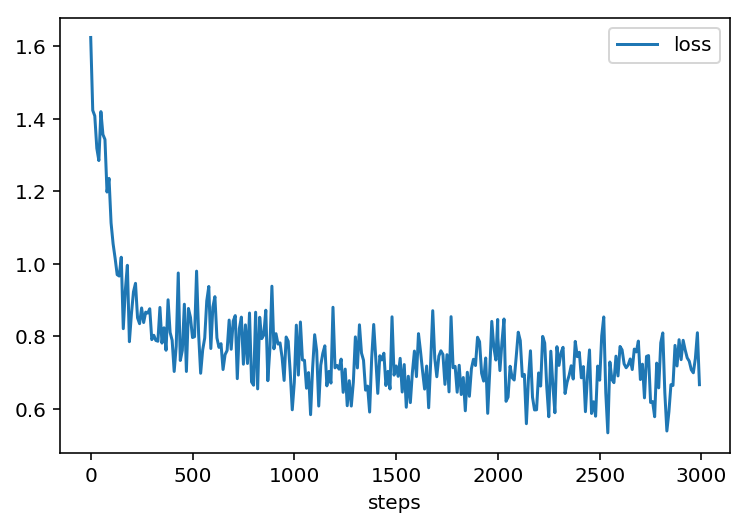

In [8]:
from smdebug.tensorflow import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from matplotlib import pyplot as plt

import pandas as pd

# Let's visualize weights of the first convolutional layer as they progressively change through training.
tensor_name = 'loss'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)

## Visualize Accuracy

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 

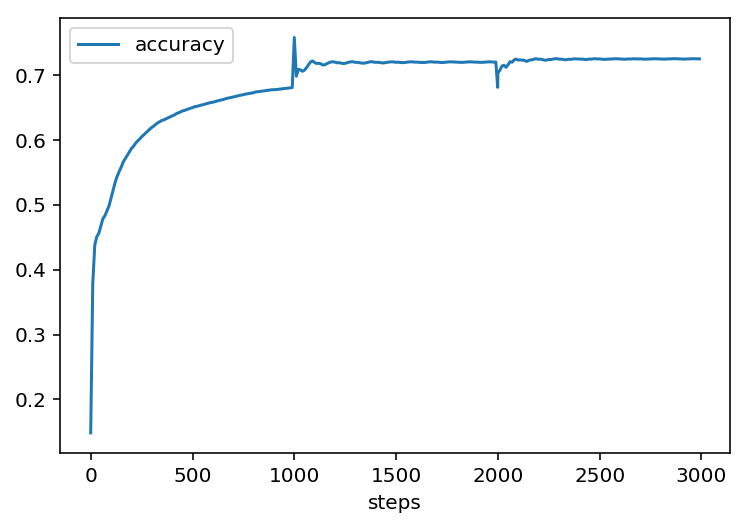

In [9]:
from smdebug.tensorflow import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from matplotlib import pyplot as plt

import pandas as pd

tensor_name = 'accuracy'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)

## TODO: Add Lambda Function to Stop the Training Job Early (and Reduce Cost)
In your AWS console, go to Lambda Management Console,
Create a new function by hitting Create Function,
Choose the language as Python 3.7 and put in the following sample code for stopping the training job if one of the Rule statuses is "IssuesFound".

### CloudWatch Events for Rules
Rule status changes in a training job trigger CloudWatch Events. These events can be acted upon by configuring a CloudWatch Rule (different from Amazon SageMaker Debugger Rule) to trigger each time a Debugger Rule changes status. In this notebook we'll go through how you can create a CloudWatch Rule to direct Training Job State change events to a lambda function that stops the training job in case a rule triggers and has status "IssuesFound".

Create a new execution role for the Lambda, and
In your IAM console, search for the role and attach "AmazonSageMakerFullAccess" policy to the role. This is needed for the code in your Lambda function to stop the training job.


### Create a CloudWatch Rule to Trigger a Lamba
In your AWS Console, go to CloudWatch and select Rule from the left column,
Hit Create Rule. The console will redirect you to the Rule creation page,
For the Service Name, select "SageMaker".
For the Event Type, select "SageMaker Training Job State Change".
In the Targets select the Lambda function you created above, and
For this example notebook, we'll leave everything as is.


#### Create the Lambda

```
import json
import boto3
import logging

def lambda_handler(event, context):
    training_job_name = event.get("detail").get("TrainingJobName")
    eval_statuses = event.get("detail").get("DebugRuleEvaluationStatuses", None)

    if eval_statuses is None or len(eval_statuses) == 0:
        logging.info("Couldn't find any debug rule statuses, skipping...")
        return {
            'statusCode': 200,
            'body': json.dumps('Nothing to do')
        }

    client = boto3.client('sagemaker')

    for status in eval_statuses:
        if status.get("RuleEvaluationStatus") == "IssuesFound":
            logging.info(
                'Evaluation of rule configuration {} resulted in "IssuesFound". '
                'Attempting to stop training job {}'.format(
                    status.get("RuleConfigurationName"), training_job_name
                )
            )
            try:
                client.stop_training_job(
                    TrainingJobName=training_job_name
                )
            except Exception as e:
                logging.error(
                    "Encountered error while trying to "
                    "stop training job {}: {}".format(
                        training_job_name, str(e)
                    )
                )
                raise e
    return None
```

* Create a new execution role for the Lambda, and
* In your IAM console, search for the role and attach "AmazonSageMakerFullAccess" policy to the role. This is needed for the code in your Lambda function to stop the training job.

#### Create a CloudWatch Rule

* In your AWS Console, go to CloudWatch and select Rule from the left column,
* Hit Create Rule. The console will redirect you to the Rule creation page,
 * For the Service Name, select "SageMaker".
 * For the Event Type, select "SageMaker Training Job State Change".
* In the Targets select the Lambda function you created above, and
* For this example notebook, we'll leave everything as is.

SageMaker kicked off rule evaluation jobs, one for each of the SageMaker rules - `Overtraining` and `LossNotDecreasing` as specified in the estimator. If we setup a CloudWatch Rule to stop the training job, we would see the `TrainingJobStatus` change to `Stopped` once the `RuleEvaluationStatus` for changes to `IssuesFound`.

In [10]:
# TODO:  
# # This utility gives the link to monitor the CW event
# def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
#         """Helper function to get the rule job name"""
#         return "{}-{}-{}".format(
#             training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
#         )
    
# def _get_cw_url_for_rule_job(rule_job_name, region):
#     return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(region, region, rule_job_name)


# def get_rule_jobs_cw_urls(estimator):
#     region = boto3.Session().region_name
#     training_job = estimator.latest_training_job
#     training_job_name = training_job.describe()["TrainingJobName"]
#     rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]
    
#     result={}
#     for status in rule_eval_statuses:
#         if status.get("RuleEvaluationJobArn", None) is not None:
#             rule_job_name = _get_rule_job_name(training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"])
#             result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(rule_job_name, region)
#     return result

# get_rule_jobs_cw_urls(estimator)